# <font color = #7B68EE> ROSSMANN Sales Store Prediction </font>

- Project REPO [ROSSMANN Sales Store Prediction](https://github.com/pmusachio/rossmann_store_sales_prediction)
- **CFO needs to plan store renovations, and to decide how much to invest in each one, he needs the daily sales forecast per store for the next 6 weeks**

# <font color = #7B68EE> 0.0 Imports </font>

In [1]:
import math
import numpy  as np
import pandas as pd
import datetime
# import random
# import pickle
# import requests
# import warnings
import inflection
import seaborn as sns
# import xgboost as xgb

# from scipy                 import stats  as ss
# from boruta                import BorutaPy
from matplotlib            import pyplot as plt
# from IPython.display       import Image
# from IPython.core.display  import HTML


# from sklearn.metrics       import mean_absolute_error, mean_squared_error
# from sklearn.ensemble      import RandomForestRegressor
# from sklearn.linear_model  import LinearRegression, Lasso
# from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

# warnings.filterwarnings( 'ignore' )

## 0.1 Helper Functions

In [2]:
# def cross_validation( x_training, kfold, model_name, model, verbose=False ):
#     mae_list = []
#     mape_list = []
#     rmse_list = []
#     for k in reversed( range( 1, kfold+1 ) ):
#         if verbose:
#             print( '\nKFold Number: {}'.format( k ) )
#         # start and end date for validation 
#         validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
#         validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

#         # filtering dataset
#         training = x_training[x_training['date'] < validation_start_date]
#         validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

#         # training and validation dataset
#         # training
#         xtraining = training.drop( ['date', 'sales'], axis=1 ) 
#         ytraining = training['sales']

#         # validation
#         xvalidation = validation.drop( ['date', 'sales'], axis=1 )
#         yvalidation = validation['sales']

#         # model
#         m = model.fit( xtraining, ytraining )

#         # prediction
#         yhat = m.predict( xvalidation )

#         # performance
#         m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

#         # store performance of each kfold iteration
#         mae_list.append(  m_result['MAE'] )
#         mape_list.append( m_result['MAPE'] )
#         rmse_list.append( m_result['RMSE'] )

#     return pd.DataFrame( {'Model Name': model_name,
#                           'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
#                           'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
#                           'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


# def mean_percentage_error( y, yhat ):
#     return np.mean( ( y - yhat ) / y )
     
    
# def mean_absolute_percentage_error( y, yhat ):
#     return np.mean( np.abs( ( y - yhat ) / y ) )

    
# def ml_error( model_name, y, yhat ):
#     mae = mean_absolute_error( y, yhat )
#     mape = mean_absolute_percentage_error( y, yhat )
#     rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
#     return pd.DataFrame( { 'Model Name': model_name, 
#                            'MAE': mae, 
#                            'MAPE': mape,
#                            'RMSE': rmse }, index=[0] )

# def cramer_v( x, y ):
#     cm = pd.crosstab( x, y ).as_matrix()
#     n = cm.sum()
#     r, k = cm.shape
    
#     chi2 = ss.chi2_contingency( cm )[0]
#     chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
#     kcorr = k - (k-1)**2/(n-1)
#     rcorr = r - (r-1)**2/(n-1)
    
#     return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )



# def jupyter_settings():
#     %matplotlib inline
#     %pylab inline
    
#     plt.style.use( 'bmh' )
#     plt.rcParams['figure.figsize'] = [25, 12]
#     plt.rcParams['font.size'] = 24
    
#     display( HTML( '<style>.container { width:100% !important; }</style>') )
#     pd.options.display.max_columns = None
#     pd.options.display.max_rows = None
#     pd.set_option( 'display.expand_frame_repr', False )
    
#     sns.set()

In [3]:
# jupyter_settings()

## 0.2 Load data

In [4]:
df_sales_raw = pd.read_csv( 'https://raw.githubusercontent.com/pmusachio/rossmann_store_sales_prediction/main/data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( 'https://raw.githubusercontent.com/pmusachio/rossmann_store_sales_prediction/main/data/store.csv', low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# <font color = #7B68EE> 1.0 Data Description </font>

In [5]:
df1 = df_raw.copy()

## 1.1 Columns Rename

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [7]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [8]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout/Replace NA

In [10]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
85535,796,6,2015-05-16,4761,389,1,0,0,0,a,c,7180.0,11.0,2012.0,0,NaN,NaN,NaN


In [11]:
#competition_distance        
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

#promo2_since_week           
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year           
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#promo_interval              
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )


In [12]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Data Types

In [13]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
    
# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7 Descriptive Statistics

In [14]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical Attributes

In [15]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


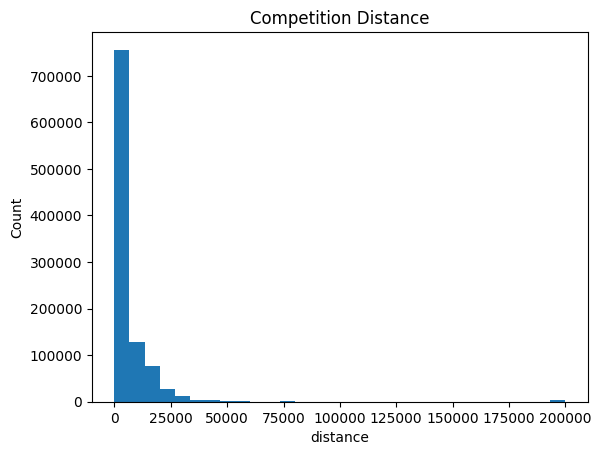

In [16]:
plt.hist(df1['competition_distance'], bins=30)
plt.xlabel('distance')
plt.ylabel('Count')
plt.title('Competition Distance');

### 1.7.2 Categorical Attributes

In [17]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

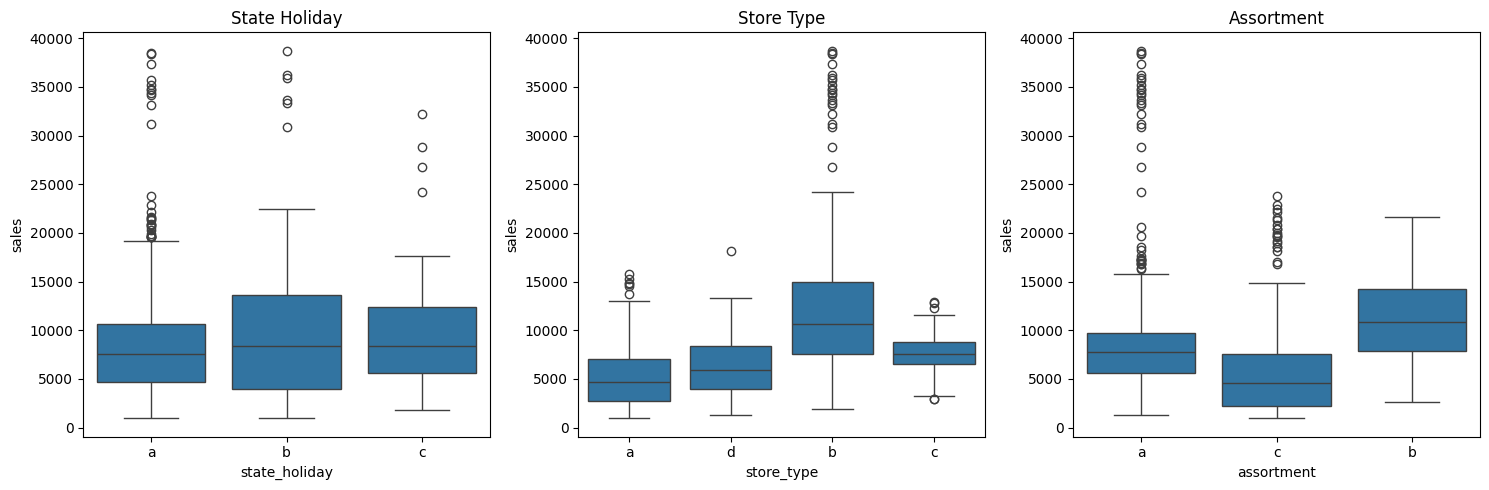

In [18]:
plt.figure(figsize=(15, 5)) # dash
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1) # state_holiday
sns.boxplot(x='state_holiday', y='sales', data=aux)
plt.title('State Holiday')

plt.subplot(1, 3, 2) # store_type
sns.boxplot(x='store_type', y='sales', data=aux)
plt.title('Store Type')

plt.subplot(1, 3, 3) # assortment
sns.boxplot(x='assortment', y='sales', data=aux)
plt.title('Assortment')

plt.tight_layout() # layout

# <font color = #7B68EE> 2.0 Feature Engineering </font>

In [19]:
df2 = df1.copy()

## 2.1 Hypothesis Mindmap

In [20]:
# Image( 'img/MindMapHypothesis.png' )

## 2.2 Hypothesis Creation

| # | Store | Product | Time |
|---|-------|---------|------|
| 1 | Stores with a larger number of employees should sell more | Stores that invest more in Marketing should sell more | <font color = GREEN> **Stores open during the Christmas holiday should sell more** </font> |
| 2 | Stores with greater stock capacity should sell more | Stores with greater product display should sell more | <font color = GREEN> **Stores should sell more over the years** </font> |
| 3 | Larger stores should sell more | Stores with lower priced products should sell more | <font color = GREEN> **Stores should sell more in the second half of the year** </font> |
| 4 | <font color = GREEN> **Stores with larger assortments should sell more** </font> | Stores with more aggressive promotions (bigger discounts) should sell more | <font color = GREEN> **Stores should sell more after the 10th of each month** </font> |
| 5 | <font color = GREEN> **Stores with closer competitors should sell less** </font> | <font color = GREEN> **Stores with active promotions for longer should sell more** </font> | <font color = GREEN> **Stores should sell less on weekends** </font> |
| 6 | <font color = GREEN> **Stores with longer competitors should sell more** </font> | <font color = GREEN> **Stores with more promotion days should sell more** </font> | <font color = GREEN> **Stores should sell less during school holidays** </font> |
| 7 | | <font color = GREEN> **Stores with more consecutive promotions should sell more** </font> | |

## 2.3 Feature Creation

In [21]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

# <font color = #7B68EE> 3.0 Data Filtering </font>

In [22]:
df3 = df2.copy()

## 3.1 Filtering Rows

In [23]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Columns Selection

In [24]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

# <font color = #7B68EE> 4.0 Exploratoria Data Analysis </font>

In [25]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

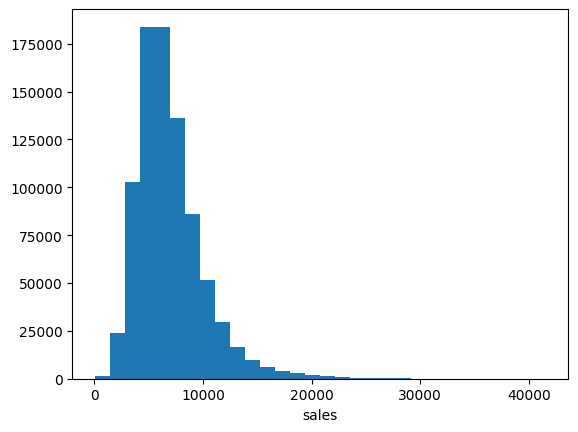

In [26]:
plt.hist(df4['sales'], bins=30)
plt.xlabel('sales');

### 4.1.2 Numerical Variable

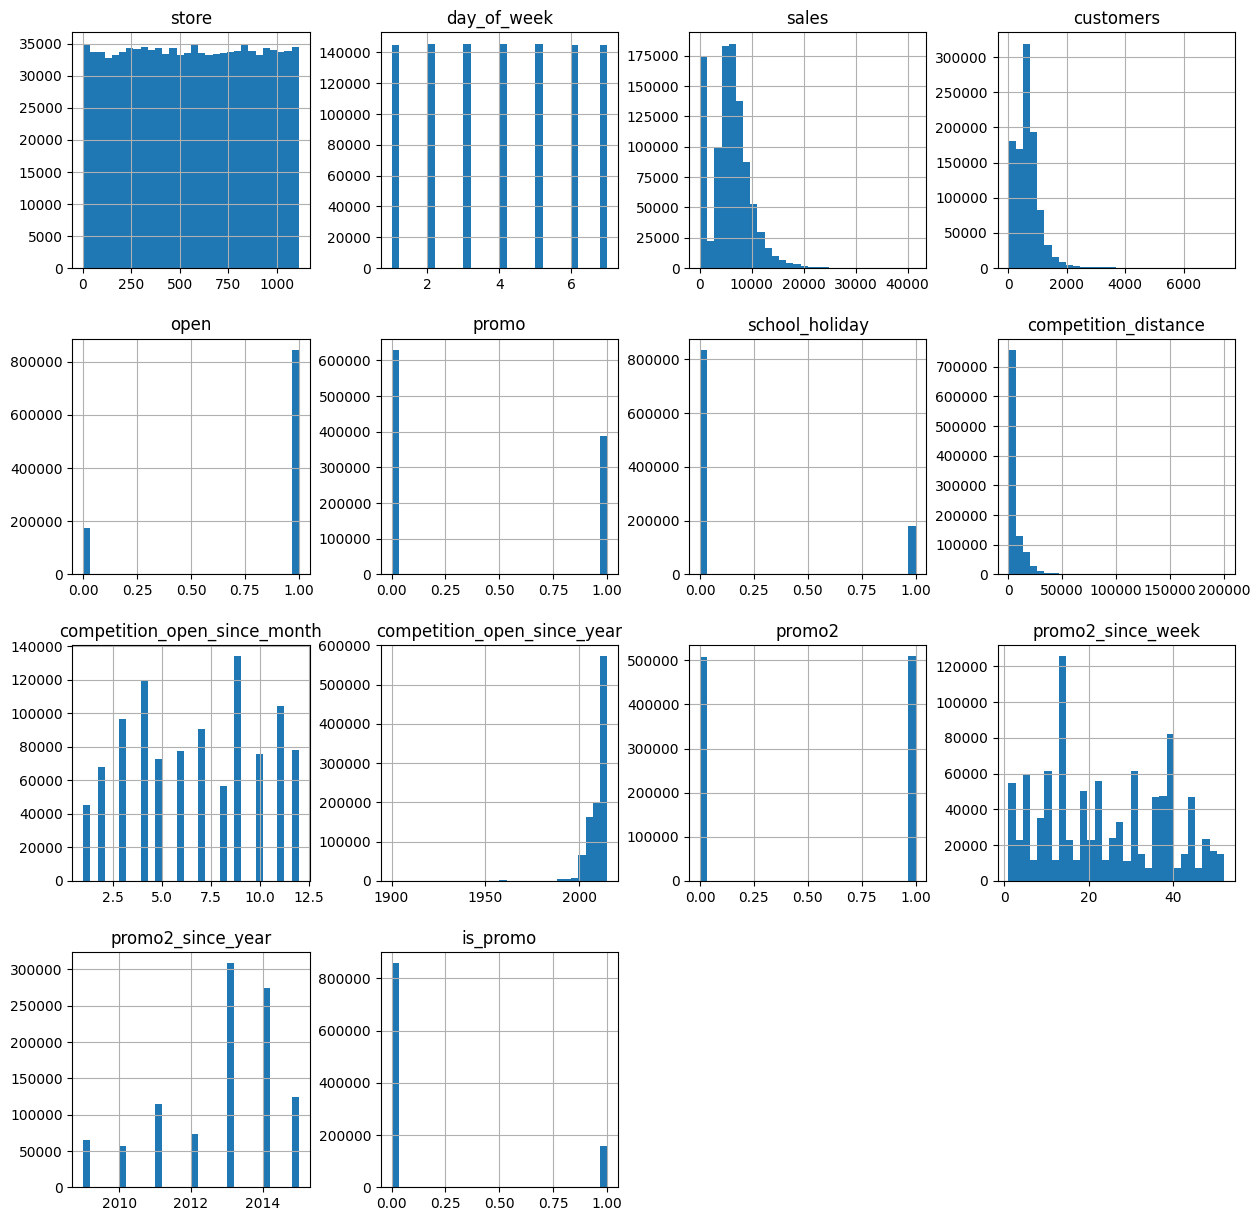

In [27]:
num_attributes.hist(bins= 30, figsize = (15,15));

### 4.1.3 Categorical Variable

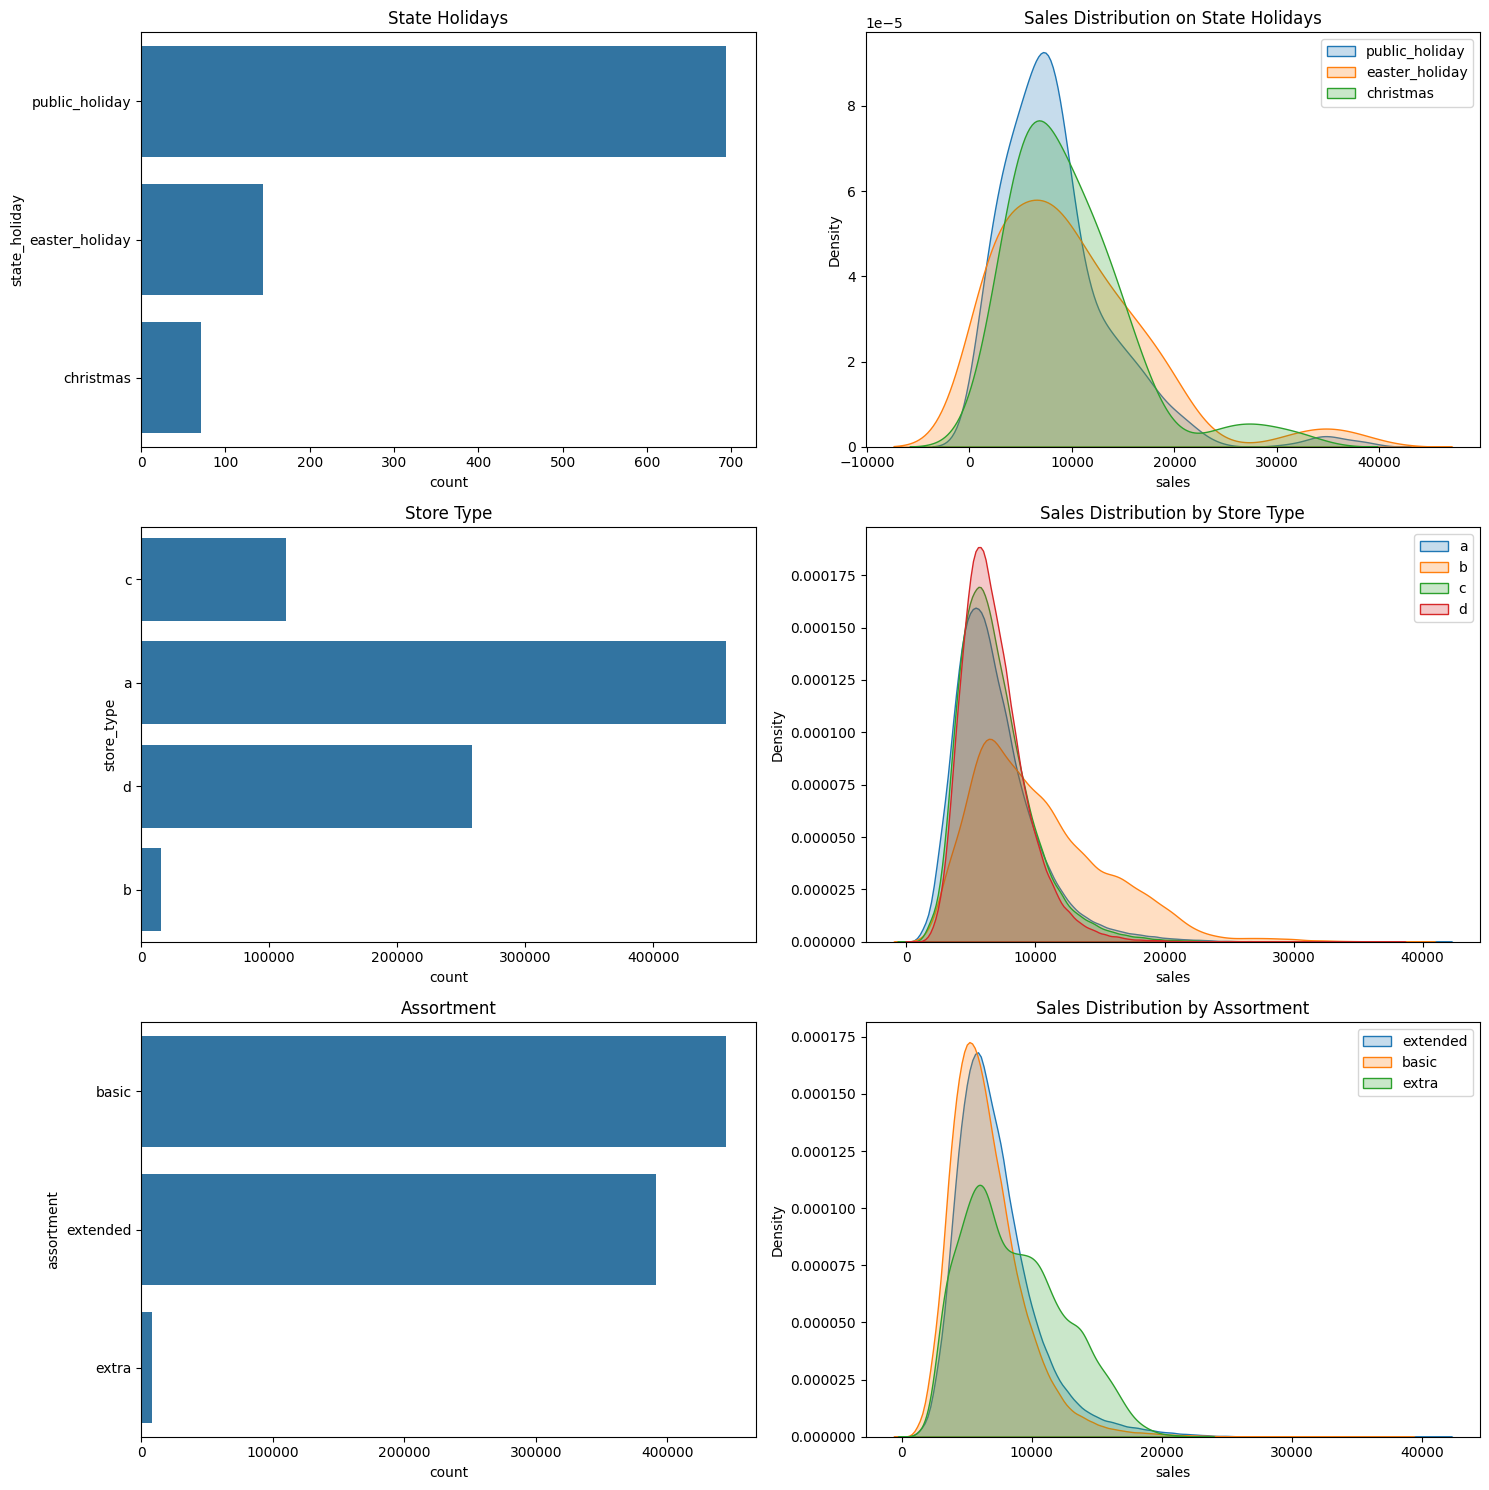

In [28]:
plt.figure(figsize=(15, 15)) # dash

# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )
plt.title('State Holidays')

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True )
plt.title('Sales Distribution on State Holidays')
plt.legend()

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )
plt.title('Store Type')

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', fill=True )
plt.title('Sales Distribution by Store Type')
plt.legend()

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )
plt.title('Assortment')

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True )
plt.title('Sales Distribution by Assortment')
plt.legend()

plt.tight_layout() # layout

## 4.2 Hypothesis Validation

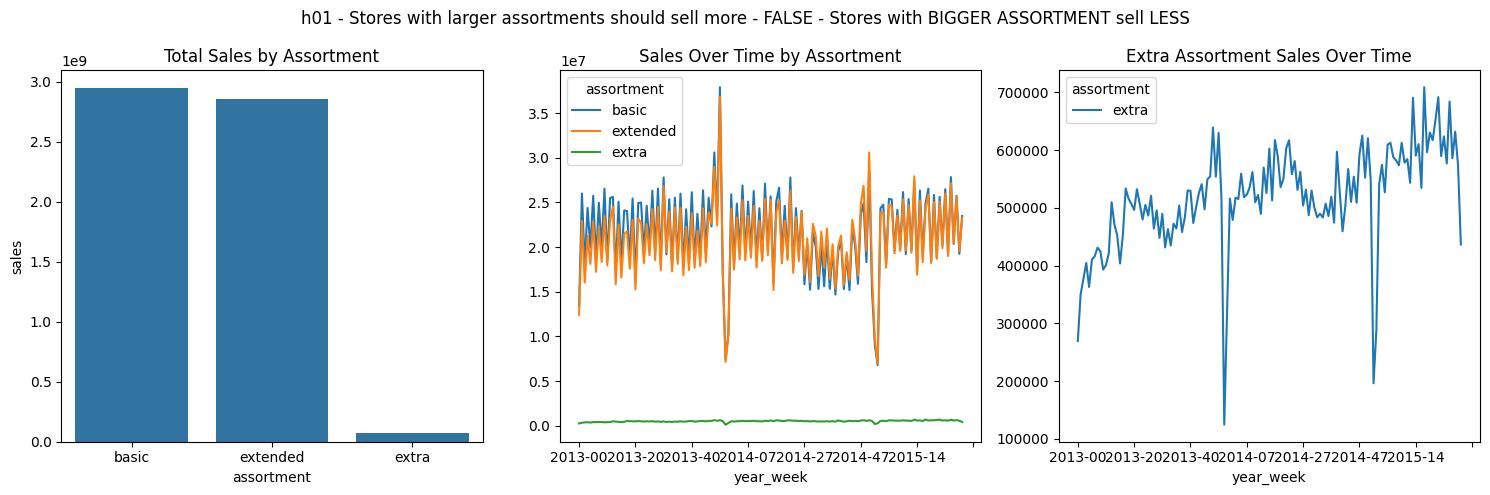

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Subplot 1
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1, ax=axes[0])
axes[0].set_title('Total Sales by Assortment')

# Subplot 2
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
pivot_aux2 = aux2.pivot(index='year_week', columns='assortment', values='sales')
pivot_aux2.plot(ax=axes[1])
axes[1].set_title('Sales Over Time by Assortment')

# Subplot 3
aux3 = aux2[aux2['assortment'] == 'extra']
pivot_aux3 = aux3.pivot(index='year_week', columns='assortment', values='sales')
pivot_aux3.plot(ax=axes[2])
axes[2].set_title('Extra Assortment Sales Over Time')

plt.suptitle('h01 - Stores with larger assortments should sell more - FALSE - Stores with BIGGER ASSORTMENT sell LESS')

# Ajustar layout
plt.tight_layout()

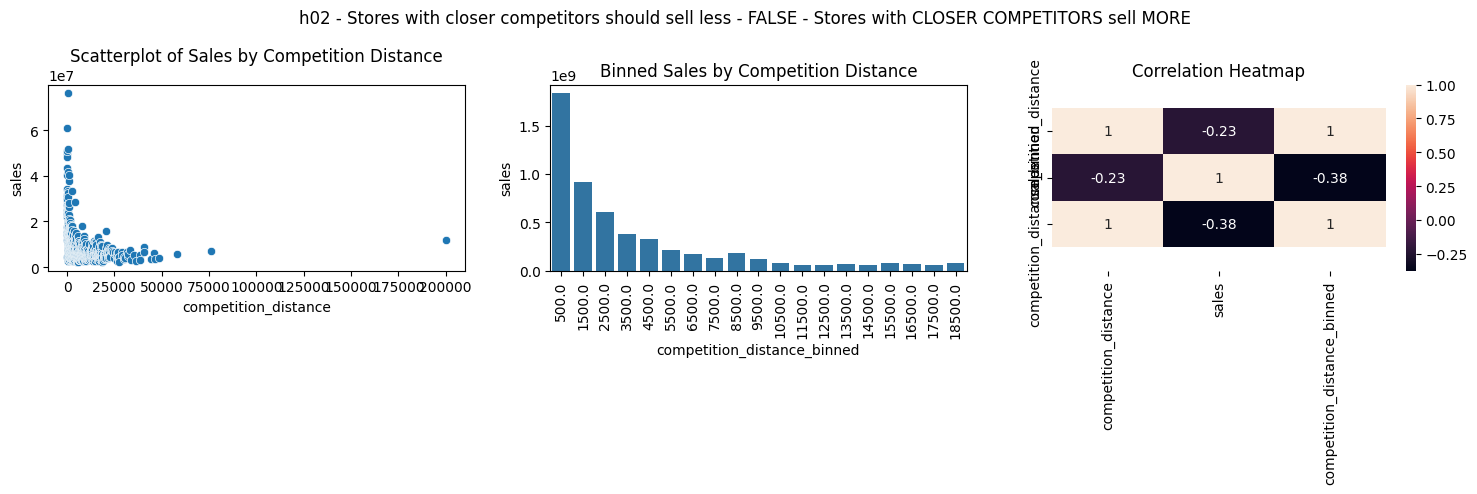

In [30]:
plt.figure(figsize=(15, 5))

# Subplot 1
plt.subplot(1, 3, 1)
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(x='competition_distance', y='sales', data=aux1)
plt.title('Scatterplot of Sales by Competition Distance')

# Subplot 2
plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux1['competition_distance_binned'] = aux1['competition_distance_binned'].apply(lambda x: x.mid)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned', observed=False).sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=90)
plt.title('Binned Sales by Competition Distance')

# Subplot 3
plt.subplot(1, 3, 3)
corr_matrix = aux1.corr(method='pearson')
sns.heatmap(corr_matrix, annot=True)
bottom, top = plt.ylim()
plt.ylim(bottom + 0.5, top - 0.5)
plt.title('Correlation Heatmap')

plt.suptitle('h02 - Stores with closer competitors should sell less - FALSE - Stores with CLOSER COMPETITORS sell MORE')

plt.tight_layout()

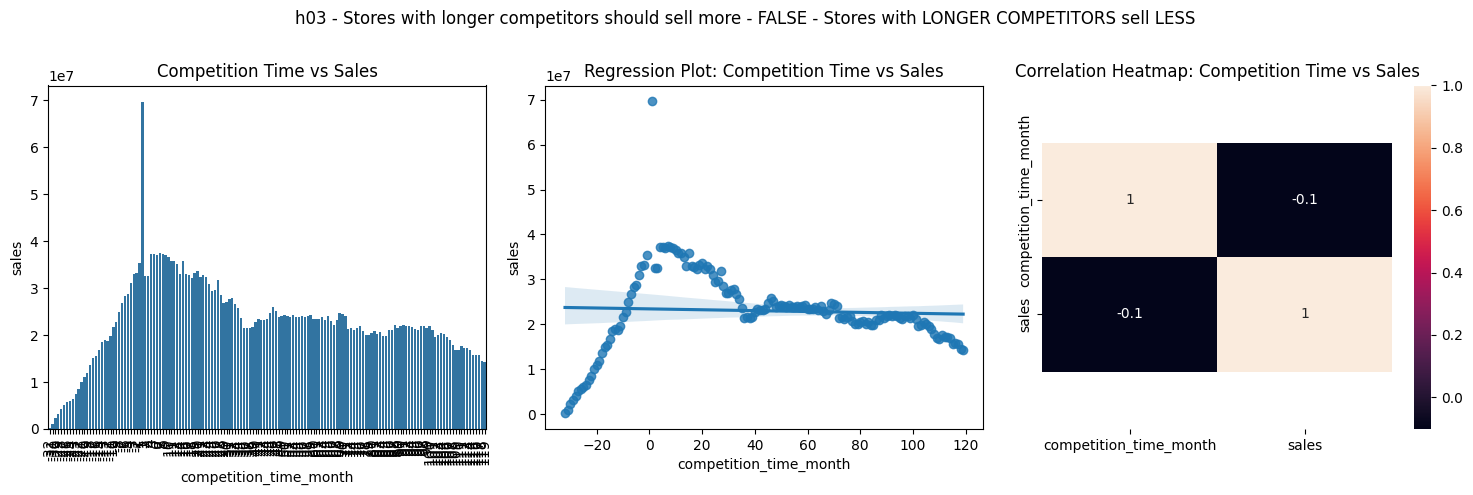

In [31]:
plt.figure(figsize=(15, 5))  # dash

# Subplot 1
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.title('Competition Time vs Sales')
plt.xticks(rotation=90)

# Subplot 2
plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)
plt.title('Regression Plot: Competition Time vs Sales')

# Subplot 3
plt.subplot(1, 3, 3)
corr_matrix = aux1.corr(method='pearson')
sns.heatmap(corr_matrix, annot=True)
bottom, top = plt.ylim()
plt.ylim(bottom + 0.5, top - 0.5)
plt.title('Correlation Heatmap: Competition Time vs Sales')

plt.suptitle('h03 - Stores with longer competitors should sell more - FALSE - Stores with LONGER COMPETITORS sell LESS')

plt.tight_layout()  # layout

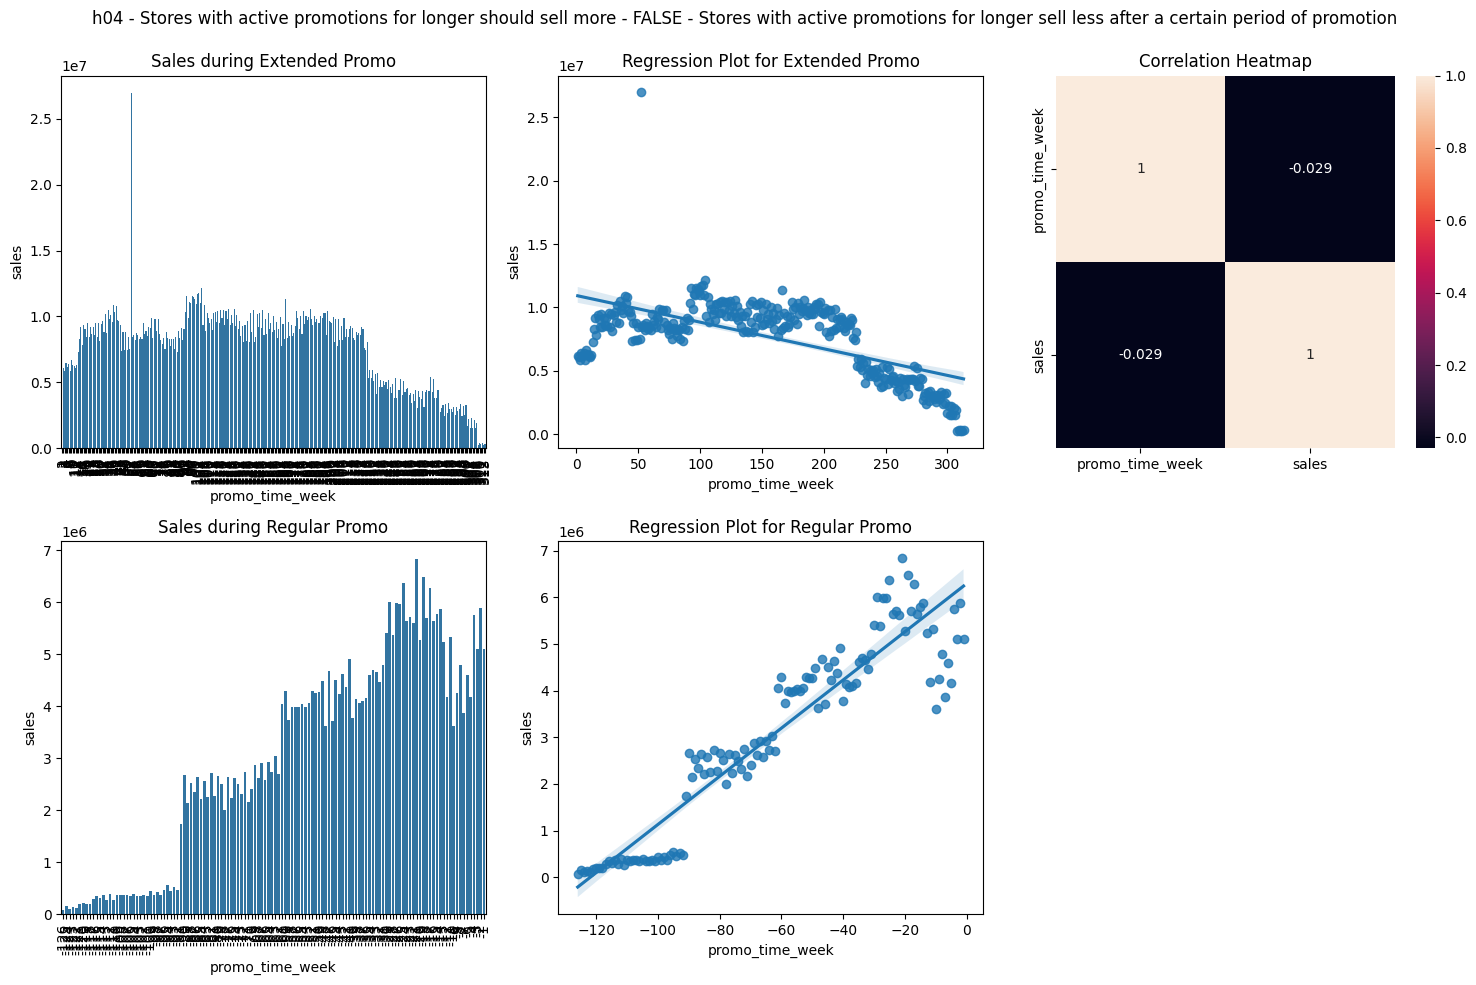

In [32]:
plt.figure(figsize=(15, 10))

aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

# Promo Extendido
plt.subplot(2, 3, 1)
aux2 = aux1[aux1['promo_time_week'] > 0]
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90)
plt.title('Sales during Extended Promo')

plt.subplot(2, 3, 2)
sns.regplot(x='promo_time_week', y='sales', data=aux2)
plt.title('Regression Plot for Extended Promo')

# Promo Regular
plt.subplot(2, 3, 4)
aux3 = aux1[aux1['promo_time_week'] < 0]
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90)
plt.title('Sales during Regular Promo')

plt.subplot(2, 3, 5)
sns.regplot(x='promo_time_week', y='sales', data=aux3)
plt.title('Regression Plot for Regular Promo')

# Correlation Heatmap
plt.subplot(2, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.title('Correlation Heatmap')

plt.suptitle('h04 - Stores with active promotions for longer should sell more - FALSE - Stores with active promotions for longer sell less after a certain period of promotion')

plt.tight_layout()

In [33]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


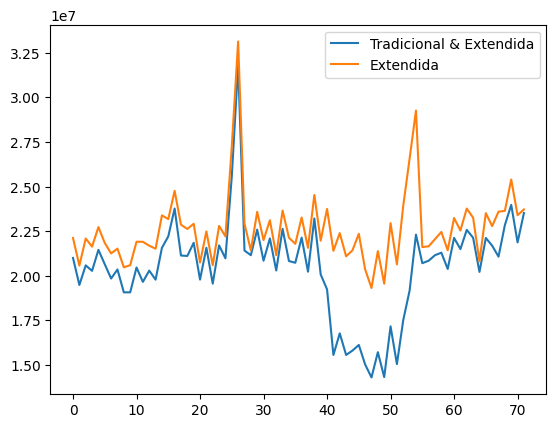

In [34]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

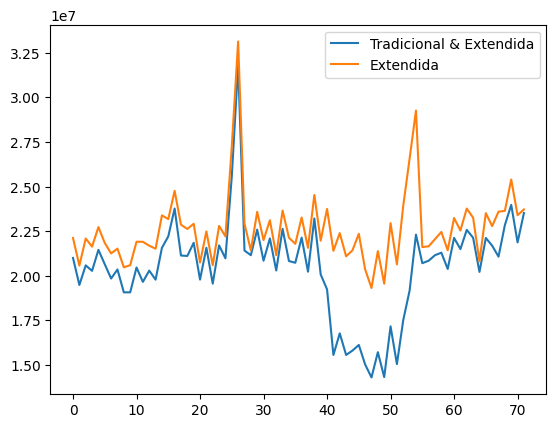

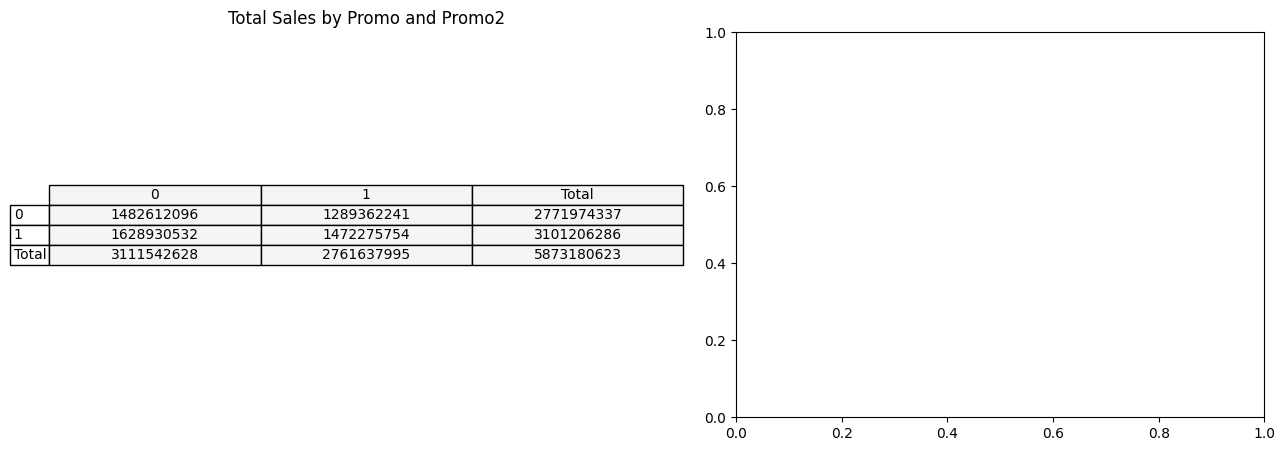

In [56]:
# Dados da tabela
table_data = df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

# Dados do primeiro gráfico
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

# Dados do segundo gráfico
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

# Adicionar legenda ao gráfico
ax.legend(labels=['Tradicional & Extendida', 'Extendida'])

# Criar uma figura com subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Subplot 1 - Tabela
table = pd.pivot_table(table_data, values='sales', index='promo', columns='promo2', aggfunc='sum', margins=True, margins_name='Total')
table_ = axes[0].table(cellText=table.values, colLabels=table.columns, rowLabels=table.index, loc='center', cellLoc='center', colColours=['#f5f5f5']*table.shape[1], cellColours=[['#f5f5f5']*table.shape[1] for _ in range(table.shape[0])])
table_.auto_set_font_size(False)
table_.set_fontsize(10)
table_.scale(1.2, 1.2)  # Ajustar escala para melhor visualização
axes[0].axis('off')  # Ocultar eixos

axes[0].set_title('Total Sales by Promo and Promo2')

# Subplot 2 - Gráfico
# axes[1].set_title('Sales Over Time for Different Promo2 Categories')
# axes[1].get_xaxis().set_visible(False)
# axes[1].get_yaxis().set_visible(False)
# plt.subplots_adjust(wspace=0.4)  # Ajustar espaço entre subplots

# Exibir a figura
plt.show()

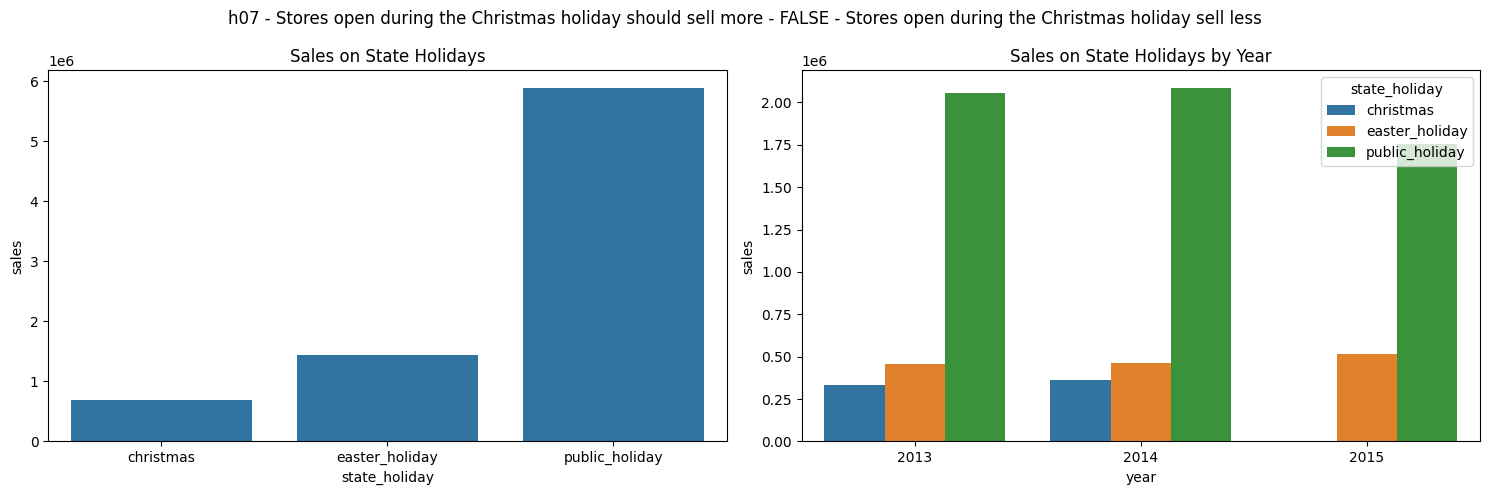

In [36]:
plt.figure(figsize=(15, 5))  # dash

# Subplot 1
plt.subplot(1, 2, 1)
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)
plt.title('Sales on State Holidays')

# Subplot 2
plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2)
plt.title('Sales on State Holidays by Year')

plt.suptitle('h07 - Stores open during the Christmas holiday should sell more - FALSE - Stores open during the Christmas holiday sell less')

plt.tight_layout()  # layout

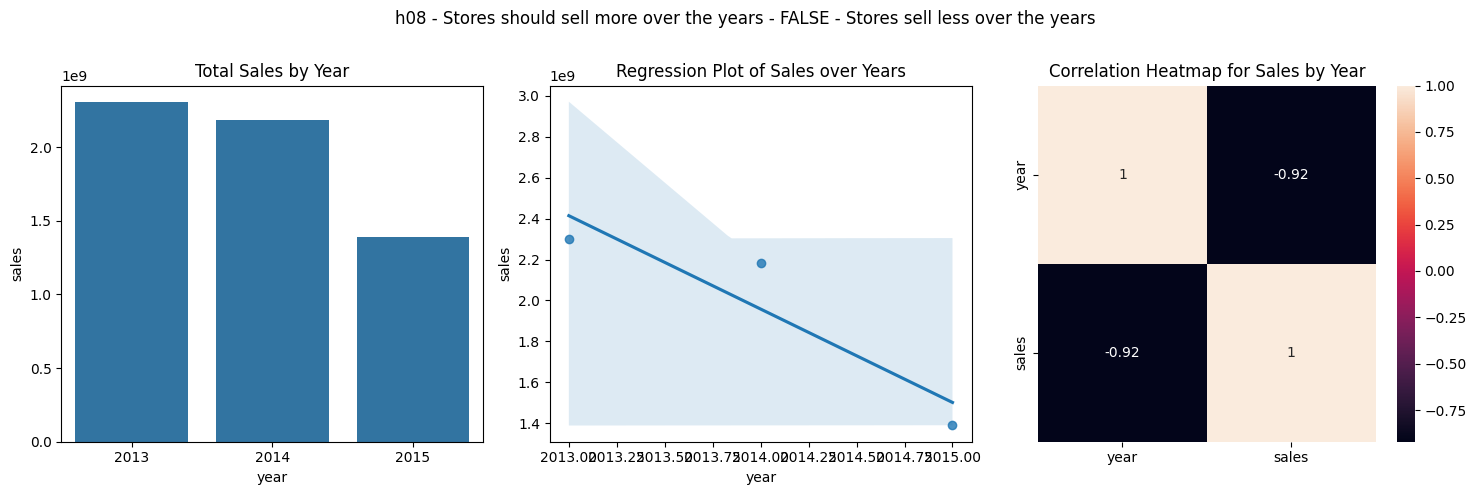

In [37]:
plt.figure(figsize=(15, 5))  # dash

# Subplot 1
plt.subplot(1, 3, 1)
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='sales', data=aux1)
plt.title('Total Sales by Year')

# Subplot 2
plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1)
plt.title('Regression Plot of Sales over Years')

# Subplot 3
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.title('Correlation Heatmap for Sales by Year')

plt.suptitle('h08 - Stores should sell more over the years - FALSE - Stores sell less over the years')

plt.tight_layout()  # layout

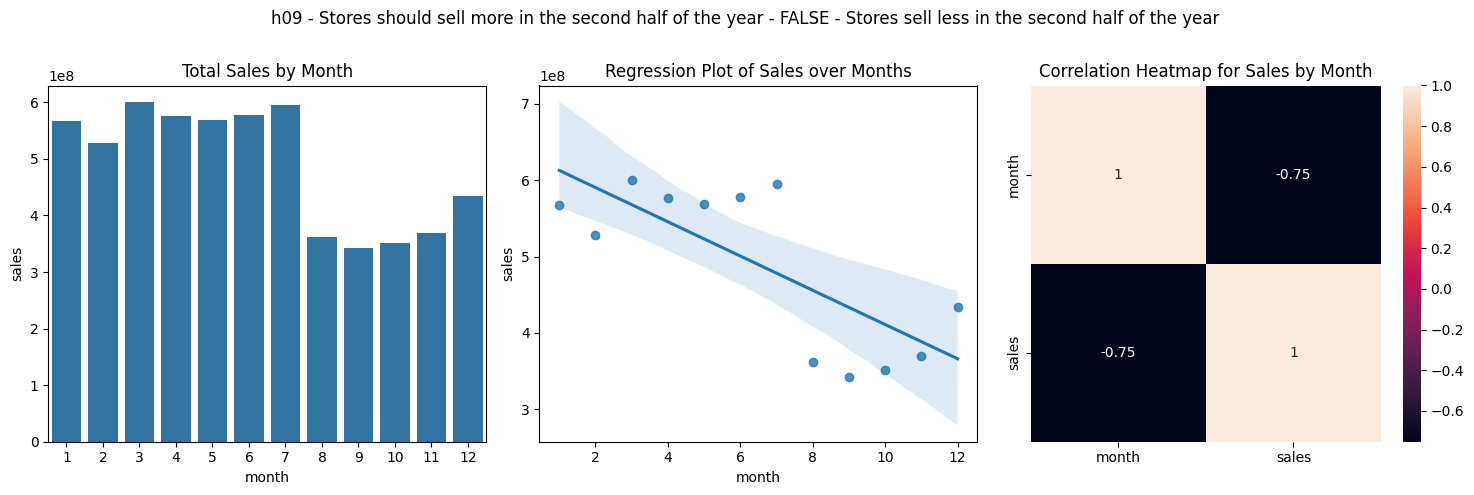

In [38]:
plt.figure(figsize=(15, 5))  # dash

# Subplot 1
plt.subplot(1, 3, 1)
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot(x='month', y='sales', data=aux1)
plt.title('Total Sales by Month')

# Subplot 2
plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1)
plt.title('Regression Plot of Sales over Months')

# Subplot 3
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.title('Correlation Heatmap for Sales by Month')

plt.suptitle('h09 - Stores should sell more in the second half of the year - FALSE - Stores sell less in the second half of the year')

plt.tight_layout()  # layout

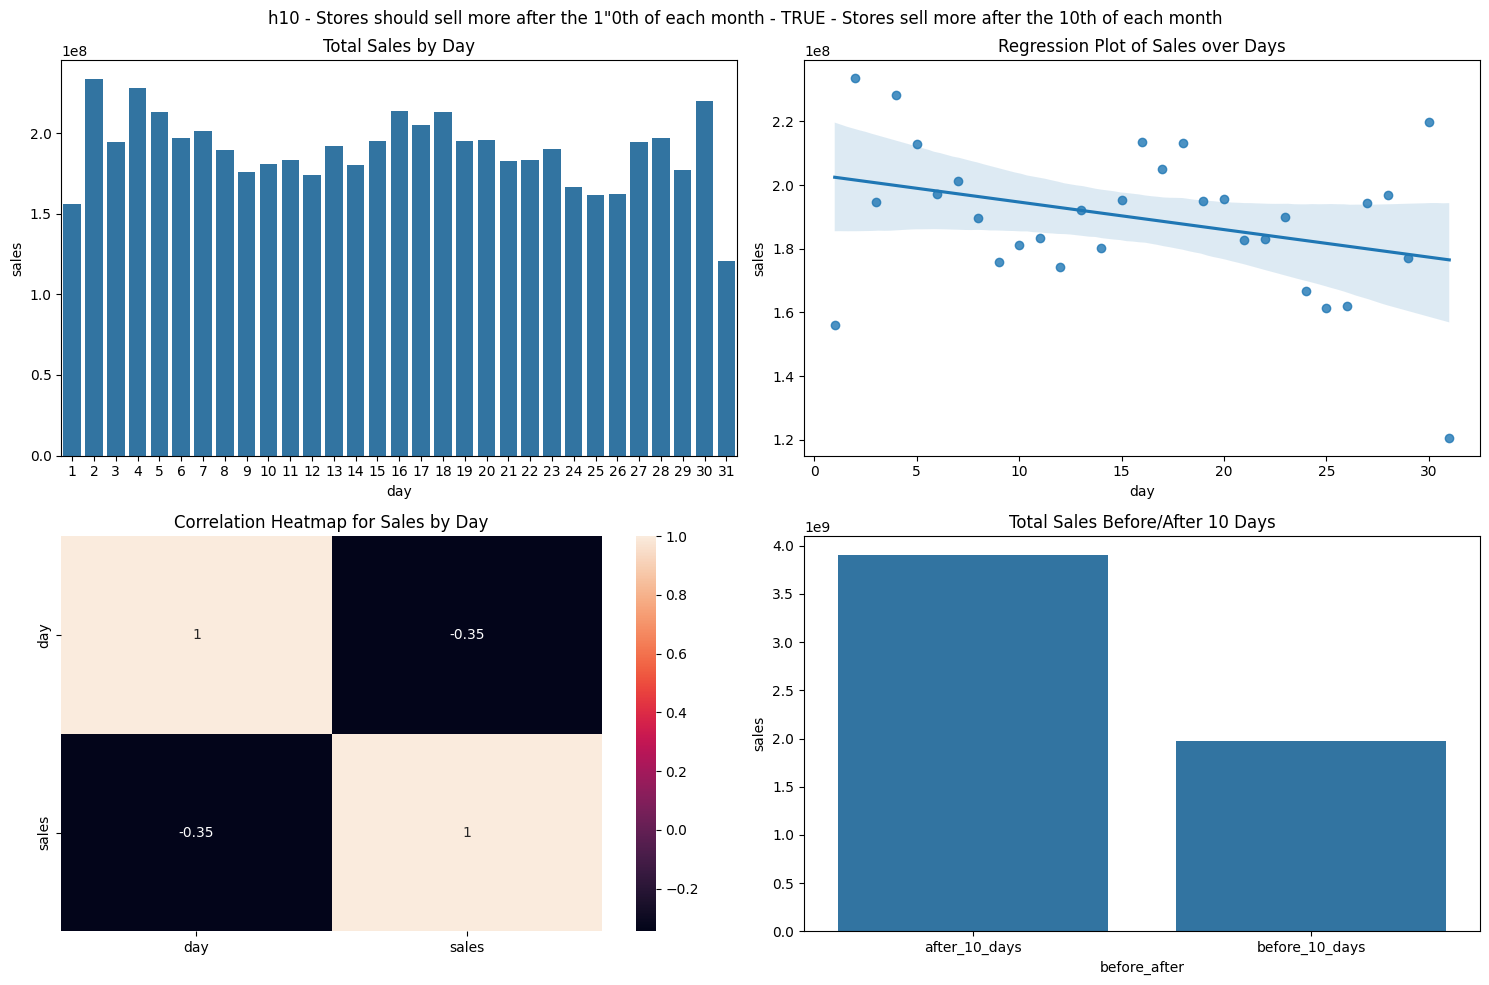

In [39]:
plt.figure(figsize=(15, 10))

# Subplot 1
plt.subplot(2, 2, 1)
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
sns.barplot(x='day', y='sales', data=aux1)
plt.title('Total Sales by Day')

# Subplot 2
plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1)
plt.title('Regression Plot of Sales over Days')

# Subplot 3
plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.title('Correlation Heatmap for Sales by Day')

# Additional Processing
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

# Subplot 4
plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2)
plt.title('Total Sales Before/After 10 Days')

plt.suptitle('h10 - Stores should sell more after the 1"0th of each month - TRUE - Stores sell more after the 10th of each month')

plt.tight_layout()  # layout

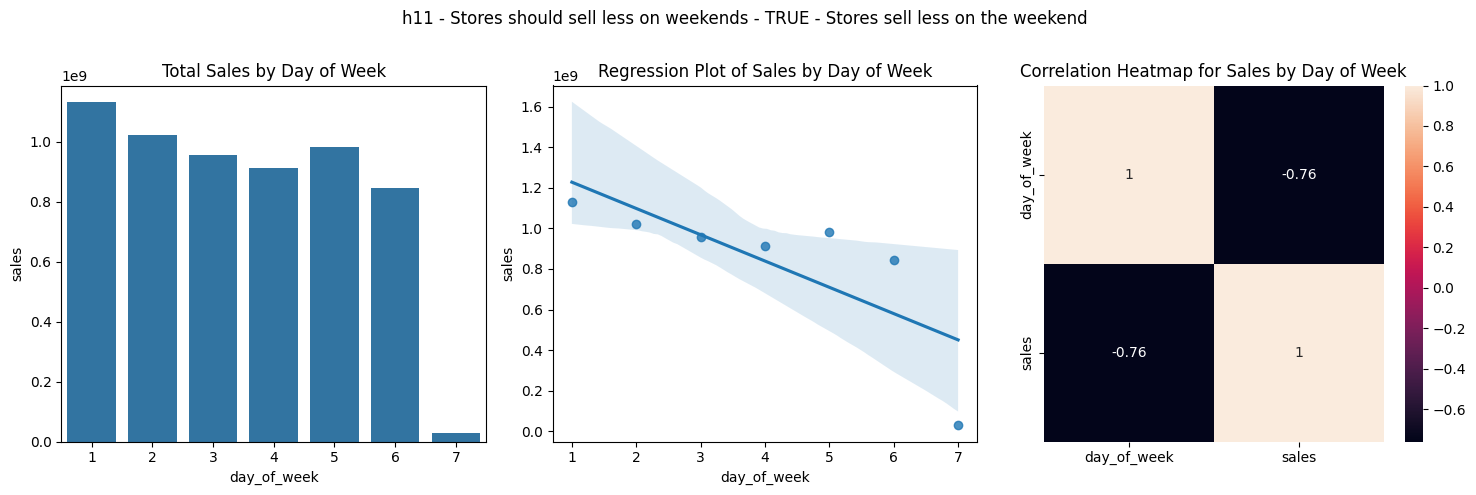

In [40]:
plt.figure(figsize=(15, 5))

# Subplot 1
plt.subplot(1, 3, 1)
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x='day_of_week', y='sales', data=aux1)
plt.title('Total Sales by Day of Week')

# Subplot 2
plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1)
plt.title('Regression Plot of Sales by Day of Week')

# Subplot 3
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.title('Correlation Heatmap for Sales by Day of Week')

plt.suptitle('h11 - Stores should sell less on weekends - TRUE - Stores sell less on the weekend')

plt.tight_layout()  # layout

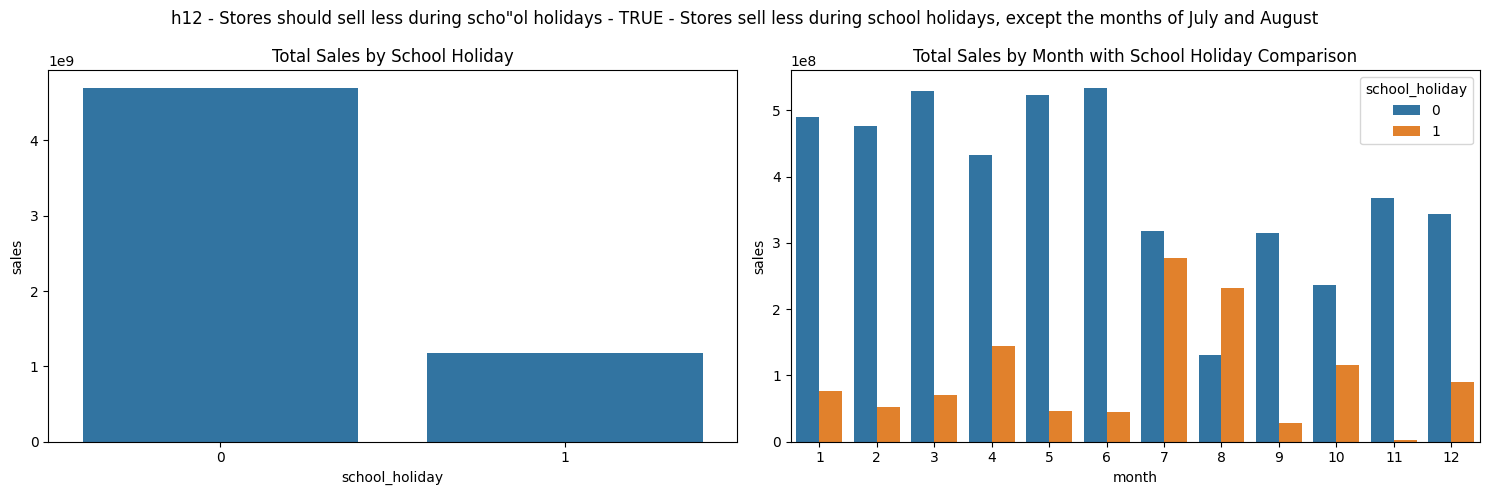

In [41]:
plt.figure(figsize=(15, 5))

# Subplot 1
plt.subplot(1, 2, 1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1)
plt.title('Total Sales by School Holiday')

# Subplot 2
plt.subplot(1, 2, 2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2)
plt.title('Total Sales by Month with School Holiday Comparison')

plt.suptitle('h12 - Stores should sell less during scho"ol holidays - TRUE - Stores sell less during school holidays, except the months of July and August')

plt.tight_layout()  # layout

In [43]:
plt.suptitle('h06 - Stores with more consecutive promotions should sell more - FALSE - Stores with more consecutive promotions sell less')

Text(0.5, 0.98, 'h06 - Stores with more consecutive promotions should sell more - FALSE - Stores with more consecutive promotions sell less')

<Figure size 640x480 with 0 Axes>

| #   | Hypothesis                                                | Conclusion                            | Comment |
|-----|-----------------------------------------------------------|---------------------------------------|---------|
| h01 | Stores with larger assortments should sell more           | <font color = RED> FALSE </font>      | Stores with BIGGER ASSORTMENT sell LESS |
| h02 | Stores with closer competitors should sell less           | <font color = RED> FALSE </font>      | Stores with CLOSER COMPETITORS sell MORE |
| h03 | Stores with longer competitors should sell more           | <font color = RED> FALSE </font>      | Stores with LONGER COMPETITORS sell LESS |
| h04 | Stores with active promotions for longer should sell more | <font color = RED> FALSE </font>      | Stores with active promotions for longer sell less after a certain period of promotion |
| h05 | ~~Stores with more promotion days should sell more~~      |                                       |  |
| h06 | Stores with more consecutive promotions should sell more  | <font color = RED> FALSE </font>      | Stores with more consecutive promotions sell less |
| h07 | Stores open during the Christmas holiday should sell more | <font color = RED> FALSE </font>      | Stores open during the Christmas holiday sell less |
| h08 | Stores should sell more over the years                    | <font color = RED> FALSE </font>      | Stores sell less over the years |
| h09 | Stores should sell more in the second half of the year    | <font color = RED> FALSE </font>      | Stores sell less in the second half of the year |
| h10 | Stores should sell more after the 10th of each month      | <font color = GREEN> **TRUE** </font> | Stores sell more after the 10th of each month |
| h11 | Stores should sell less on weekends                       | <font color = GREEN> **TRUE** </font> | Stores sell less on the weekend |
| h12 | Stores should sell less during school holidays            | <font color = GREEN> **TRUE** </font> | Stores sell less during school holidays, except the months of July and August |

## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

### 4.3.2 Categorical Attributes

# <font color = #7B68EE> 5.0 Data Preparation </font>

In [44]:
df5 = df4.copy()

## 5.1 Standardization

## 5.2 Rescaling

## 5.3 Transformation

### 5.3.1 Encoding

### 5.3.2 Response Variable Transformation

### 5.3.3 Magnitude Transformation - Variável Resposta

### 5.3.4 Nature Transformation

## 5.4 Preparing Validation Data

# <font color = #7B68EE> 6.0 Feature Selection </font>

In [45]:
df6 = df5.copy()

## 6.1 Split dataframe Training/Test

## 6.2 Feature Selector

### 6.2.1 Feature Selector Algorithm (boruta, xtra trees)

### 6.2.2 Feature Importance

## 6.3 Manual Feature Selection

# <font color = #7B68EE> 7.0 Machine Learning Modelling </font>

In [46]:
df7 = df6.copy()

## 7.1 Data Preparation

## 7.2 Algorithms ML

## 7.2.1 Model 1, Treinamento, Previsao

## 7.2.2 Model 2, Treinamento, Previsao

## 7.2.3 Model 3, Treinamento, Previsao

## 7.3 Compare Model's Performance

### 7.3.1 Single Performance (W/O Cross-Validation)

### 7.3.2 Real Performance (W/ Cross-Validation)

## 7.4 Cumulative Gain

# <font color = #7B68EE> 8.0 Hyperparameter Fine-Tunning </font>

In [47]:
df8 = df7.copy()

## 8.1 Usando o Optuna

## 8.2 Final Model (modelo, treinamento, previsao, performance)

# <font color = #7B68EE> 9.0 Performance Metrics </font>

In [48]:
df9 = df8.copy()

- Cummulative Curve Manually
- Lift Curve Manually
- ROI Curve Manually

## 9.1 Business Performance

## 9.2 Total Performance

## 9.3 Machine Learning Performance

# <font color = #7B68EE> 10.0 Deploy to Production </font>

In [49]:
df10 = df9.copy()

## 10.1 Project Class

## 10.2 API Handler

## 10.3 API Tester